#Requirements

In [ ]:
!pip install scikit-image
!pip install opencv-python-headless
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install feature-engine
!pip install scipy

#Imports

In [2]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import random

from skimage.color import rgb2hsv, rgb2ycbcr
from skimage.transform import resize
from skimage.feature import hog

from scipy.ndimage import rotate
from feature_engine.selection import DropConstantFeatures,SmartCorrelatedSelection

from sklearn.model_selection import train_test_split,learning_curve,GridSearchCV,ShuffleSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preparation

## Transform the videos into image features

In [ ]:
#For potential data augmentation
"""def rotation(image, seed=777,rota=0):
    random.seed(seed)
    angle= rota
    r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return r_img

def v_transl(image, seed=777,decalage=0):
    random.seed(seed)
    n_pixels = decalage
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed=777,decalage=0):
    random.seed(seed)
    n_pixels = decalage
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img"""

In [4]:
label2int = {
    'dislike' : 0,
    'like' : 1,
    'ok' : 2,
    'point' : 3,
    'slide_1' : 4,
    'slide_2' : 5,
    'take_a_picture' : 6
}

X_set = []
Y_set = []
for path_director in glob.glob('/content/drive/MyDrive/demo_room/*'):

  label1 = path_director.split('/')[-1]
  print(label1)
  for image_path in glob.glob(path_director+'/*'):
      cap=cv2.VideoCapture(image_path)

      label = image_path.split('/')[-1].split('_')[0]
      if label=='slide' or label=='take'  :
        label=label+'_'+image_path.split('/')[-1].split('_')[1]
        if label=='take_a':
          label=label+'_'+image_path.split('/')[-1].split('_')[2]
      nb=0
      while cap.isOpened():

        imageId=cap.get(1)
        ret,image=cap.read()
        if ret !=True:
          break

        if imageId != 0 and imageId % 4 == 0:
            nb=nb+1
            image=cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

            if image.ndim==3:
              image = cv2.GaussianBlur(image, (5,5) , 100)
              red , green , blue = image[:,:,0] ,image[:,:,1] , image[:,:,2]

              #get the HSV version
              image_hsv = rgb2hsv(image)
              hue = image_hsv[:,:,0]
              sat = image_hsv[:,:,1]

              #get the ycbcr version
              image_ycbcr = rgb2ycbcr(image)
              y = image_ycbcr[:,:,0]
              cb = image_ycbcr[:,:,1]
              cr = image_ycbcr[:,:,2]

              """#HSV+RBGA mask for hand extraction
              mask = (hue>=0) & (hue<=0.13888) & (sat>=0.23) & (sat<=0.68) & (red>95) & (green > 40) & (blue > 20) & (red > green) & (red > blue) & (np.abs(red - green) > 15)
              """
              #YCBCR+RGBA mask for hand extraction
              mask = (red > 95) & (green > 40) & (blue > 20) & (red > green) & (red > blue) & (np.abs(red - green) > 15) & (cr > 135) & (cb > 85) & (y > 80) & (cr <= (1.5862*cb)+20) & (cr >= (0.3448*cb)+76.2069) & (cr >= (-4.5652*cb)+234.5652) & (cr <= (-1.15 * cb)+301.75) & (cr <= (-2.2857*cb)+432.85)

              mask = mask.astype(np.uint8)
              mask[mask == 1] = 255
              np.sum(mask == 255)


              kernel = np.ones((5,5), np.uint8)
              mask1 = cv2.erode(mask , kernel , iterations=2)
              image = cv2.dilate(mask1 , kernel , iterations=4)
              image=resize(image,(128,128))

              #feature extraction
              #Hog coefficients
              fd, _ = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
              #Hu moments
              hu_moments = cv2.HuMoments(cv2.moments(image)).flatten()
              x = np.hstack((fd,hu_moments))

              X_set.append(x)
              Y_set.append(label2int[label])
print(len(X_set))
print(len(Y_set))


subject_5
subject_4
subject_3
subject_1
subject_2
6029
6029


##Save the obtained data

In [5]:
np.savetxt("X_Data.txt", X_set, delimiter=" ")

with open("Y_Data.txt", "w") as f:
    for s in Y_set:
        f.write(str(s) +"\n")

len(X_set)

6029

In [6]:
url="/content/X_Data.txt"
url2="/content/Y_Data.txt"
names = []
for i in range (1,3788):
  names.append('Col_'+str(i))
X=pd.read_csv(url,names=names,delim_whitespace=True)
names2=["classe"]
Y=pd.read_csv(url2,names=names2)
print(X.shape,Y.shape)

(6029, 3787) (6029, 1)


##Split into train and test sets




In [7]:
X_train,X_test,Y_train,Y_test= train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=123, stratify=Y )

scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print(X_train.shape, X_test.shape, Y_train.shape,Y_test.shape)

(4823, 3787) (1206, 3787) (4823, 1) (1206, 1)


##Feature selection

In [8]:
transformer = DropConstantFeatures(tol=0.95)
transformer.fit(pd.DataFrame(X_train))
X_train = transformer.transform(pd.DataFrame(X_train))
X_test = transformer.transform(pd.DataFrame(X_test))

print(len(transformer.features_to_drop_))
print(X_train.shape,X_test.shape)

1851
(4823, 1936) (1206, 1936)


In [9]:
transformer = SmartCorrelatedSelection(estimator=KNeighborsClassifier(), scoring='accuracy', cv=5)
transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

print(len(transformer.features_to_drop_))
print(X_train.shape,X_test.shape)

1043
(4823, 893) (1206, 893)


In [10]:
pca = PCA(n_components=0.95, svd_solver='full')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(X_train.shape, X_test.shape, Y_train.shape , Y_test.shape)

(4823, 547) (1206, 547) (4823, 1) (1206, 1)


#Machine learning techniques

## k-Nearest Neighbors (KNN)

###Hyperparameter tuning

In [11]:
param={'n_neighbors':np.arange(1,20),'metric':['euclidean','manhattan']}
grid=GridSearchCV(KNeighborsClassifier(),param,cv=3)
grid.fit(X_train,Y_train)

print(grid.best_score_)
print(grid.best_params_)

0.7441412518407754
{'metric': 'euclidean', 'n_neighbors': 1}


###Cross Validation

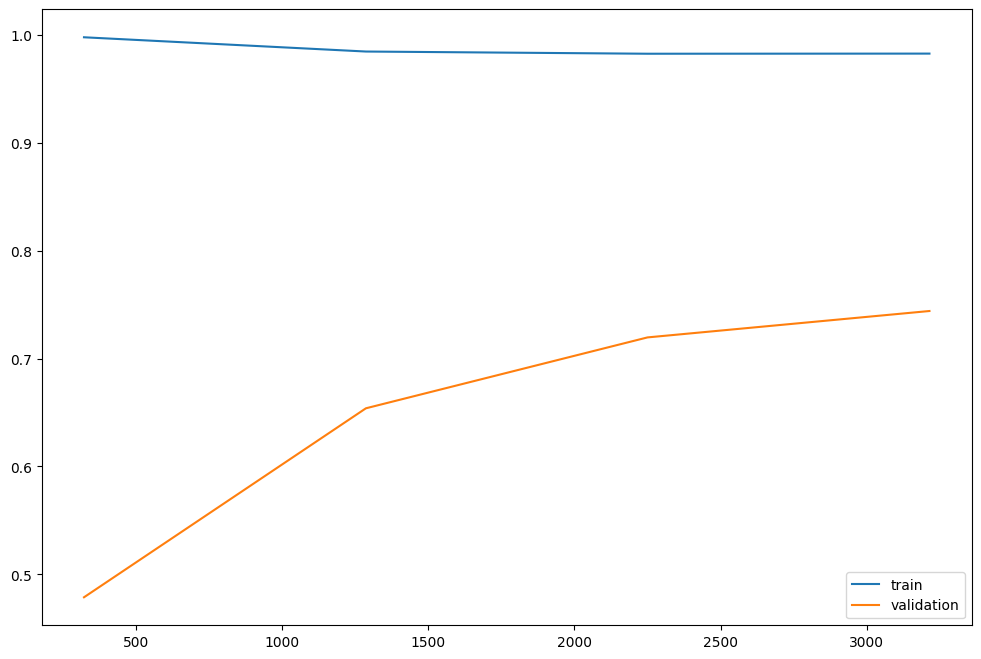

(array([0.99792316, 0.9847071 , 0.98266667, 0.98278901]),
 array([0.4787444 , 0.65394739, 0.71967493, 0.74414125]))

In [12]:
Model_KNN=KNeighborsClassifier(n_neighbors=1,p=2)

N, train_val, test_val = learning_curve(Model_KNN,X_train ,Y_train,cv=3,train_sizes=np.linspace(0.1,1,4),scoring='accuracy')
plt.figure(figsize=(12,8))
plt.plot(N, train_val.mean(axis = 1), label='train')
plt.plot(N, test_val.mean(axis = 1), label='validation')
plt.legend()
plt.show()
train_val.mean(axis=1), test_val.mean(axis=1)

###Training and testing

In [13]:
Model_KNN.fit(X_train,Y_train)

Y_pred_KNN=Model_KNN.predict(X_test)
print(classification_report(Y_test,Y_pred_KNN))
print(confusion_matrix(Y_test, Y_pred_KNN))

kappa = cohen_kappa_score(Y_test, Y_pred_KNN)
print("Kappa score", kappa)

roc = roc_auc_score(Y_test, Model_KNN.predict_proba(X_test), multi_class ='ovr')
print("Roc score", roc)

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       198
           1       0.80      0.84      0.82       184
           2       0.73      0.82      0.77       190
           3       0.75      0.79      0.77       180
           4       0.62      0.68      0.65       118
           5       0.67      0.68      0.68       114
           6       0.95      0.77      0.85       222

    accuracy                           0.77      1206
   macro avg       0.76      0.76      0.76      1206
weighted avg       0.78      0.77      0.77      1206

[[147   6   8  16  12   6   3]
 [  3 154   9   6   6   5   1]
 [  4   8 156  11   6   4   1]
 [  6   8  16 142   4   4   0]
 [  3   6  10   5  80  10   4]
 [ 11   5   2   4  14  78   0]
 [ 12   5  12   6   8   9 170]]
Kappa score 0.7284984846382014
Roc score 0.8606146756843204



## Support Vector Machine (SVM)

###Cross Validation

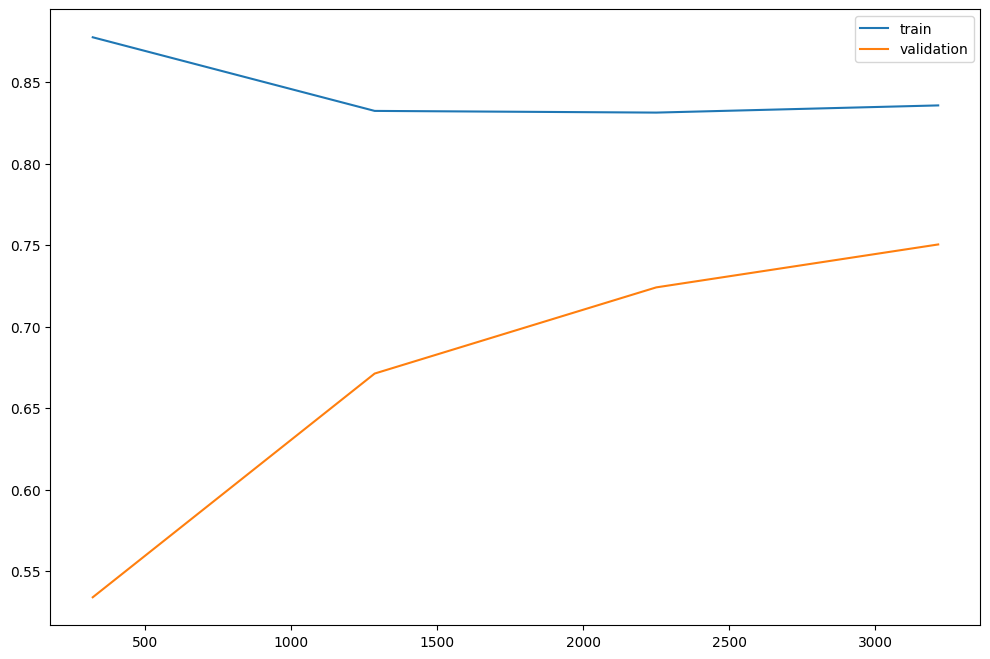

(array([0.87746625, 0.83229653, 0.83125926, 0.83566615]),
 array([0.53390071, 0.67115818, 0.72402868, 0.75036106]))

In [14]:
Model_SVM = SVC(C=30.3, kernel='rbf', gamma=2e-5)

N, train_val, test_val = learning_curve(Model_SVM, X_train, Y_train, cv=3, train_sizes=np.linspace(0.1,1,4), scoring='accuracy')
plt.figure(figsize=(12,8))
plt.plot(N, train_val.mean(axis = 1), label='train')
plt.plot(N, test_val.mean(axis = 1), label='validation')
plt.legend()
plt.show()
train_val.mean(axis=1), test_val.mean(axis=1)

###Training and testing

In [15]:
Model_SVM.fit(X_train, Y_train)

Y_pred_SVM = Model_SVM.predict(X_test)

print(classification_report(Y_test, Y_pred_SVM))
print(confusion_matrix(Y_test, Y_pred_SVM))

kappa = cohen_kappa_score(Y_test, Y_pred_SVM)
print("Kappa score", kappa)

roc = roc_auc_score(Y_test, Model_KNN.predict_proba(X_test), multi_class ='ovr')
print("Roc score", roc)



              precision    recall  f1-score   support

           0       0.87      0.78      0.82       198
           1       0.78      0.78      0.78       184
           2       0.72      0.73      0.73       190
           3       0.65      0.74      0.69       180
           4       0.72      0.53      0.61       118
           5       0.53      0.76      0.62       114
           6       0.96      0.84      0.90       222

    accuracy                           0.75      1206
   macro avg       0.75      0.74      0.74      1206
weighted avg       0.77      0.75      0.76      1206

[[154   3   6   9   2  19   5]
 [  1 143   9  21   1   9   0]
 [  3  12 139  22   6   8   0]
 [  3   9  16 134   4  14   0]
 [  3   8  17  12  63  13   2]
 [  9   7   2   3   6  87   0]
 [  4   2   4   5   5  15 187]]
Kappa score 0.7091139363040883
Roc score 0.8606146756843204


##Random forest

###Cross validation

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

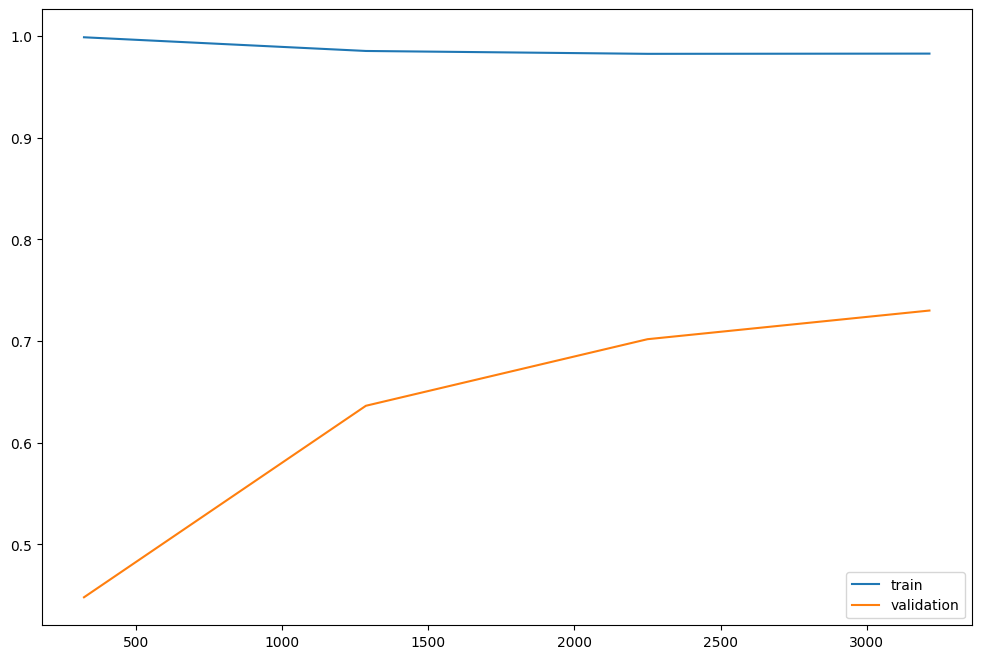

(array([0.99896158, 0.98548471, 0.98266667, 0.98289269]),
 array([0.44785975, 0.63632548, 0.7018425 , 0.73004274]))

In [16]:
Model_RF = RandomForestClassifier(n_estimators=400)

N, train_val, test_val = learning_curve(Model_RF, X_train, Y_train, cv=3, train_sizes=np.linspace(0.1,1,4),scoring='accuracy')
plt.figure(figsize=(12,8))
plt.plot(N, train_val.mean(axis = 1), label='train')
plt.plot(N, test_val.mean(axis = 1), label='validation')
plt.legend()
plt.show()
train_val.mean(axis=1), test_val.mean(axis=1)

###Training and testing

In [17]:
Model_RF.fit(X_train, Y_train)
Y_pred_RF = Model_RF.predict(X_test)

print(classification_report(Y_test , Y_pred_RF))
print(confusion_matrix(Y_test , Y_pred_RF))

kappa = cohen_kappa_score(Y_test, Y_pred_RF)
print("Kappa score", kappa)

roc = roc_auc_score(Y_test, Model_KNN.predict_proba(X_test), multi_class ='ovr')
print("Roc score", roc)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.85      0.76      0.80       198
           1       0.76      0.82      0.79       184
           2       0.75      0.80      0.78       190
           3       0.75      0.78      0.77       180
           4       0.58      0.53      0.56       118
           5       0.65      0.62      0.64       114
           6       0.86      0.86      0.86       222

    accuracy                           0.76      1206
   macro avg       0.74      0.74      0.74      1206
weighted avg       0.76      0.76      0.76      1206

[[151   4   3  11   8  10  11]
 [  3 150  11  10   5   2   3]
 [  5  11 152  10   5   5   2]
 [  4  11  15 141   3   3   3]
 [  5   7  17  10  63   9   7]
 [ 10   7   0   4  16  71   6]
 [  0   7   4   2   8   9 192]]
Kappa score 0.7209024571420248
Roc score 0.8606146756843204
